this jupyter notebook has to be same directory with Subclassing

## load dataset

In [1]:
from Subclassing.datasets import sampled_dataset

sample_data = sampled_dataset.load_data()
print(sample_data.shape)

(5000, 785)


In [2]:
from Subclassing.utils import dataset_split

data_feature, data_target = dataset_split(sample_data)
print(data_feature.shape, data_target.shape)

(5000, 28, 28, 1) (5000,)


In [3]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(data_feature, data_target, test_size=0.2)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.3)

print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)
print(x_test.shape, y_test.shape)

(2800, 28, 28, 1) (2800,)
(1200, 28, 28, 1) (1200,)
(1000, 28, 28, 1) (1000,)


## load model class

load submodels

you should build model before 

In [4]:
from Subclassing.models import LeNet5, VGG16

num_of_classes = 36

sub_1 = LeNet5(num_of_classes)
sub_2 = VGG16(num_of_classes)

from Subclassing.utils import build_model

sub_1 = build_model(sub_1, input_shape=(28,28,1))
sub_2 = build_model(sub_2, input_shape=(28,28,1))


2023-02-12 11:52:54.237509: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


or you can use this instead

In [5]:
# from keras.layers import Input
# from keras import Model

# input_layer = Input(shape=(28,28,1))

# sub_1 = Model(inputs=[input_layer], outputs=[sub_1(input_layer)])
# sub_2 = Model(inputs=[input_layer], outputs=[sub_2(input_layer)])

now you should load weight (pre-trained) of each submodels

In [6]:
from Subclassing.load_trained_model import load_trained_lenet5, load_trained_vgg16

load_trained_lenet5(sub_1)
load_trained_vgg16(sub_2)

sub_1.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
sub_2.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

you should denote that supermodel will be automatically compiled

watch docstring of Ensemble.__init__()

In [7]:
from Subclassing.models import Ensemble

sub_list = [sub_1, sub_2]

modeel = Ensemble(sub_list, num_of_classes)
modeel.summary()

Number of submodels : 2
Submodels : ['LeNet5', 'VGG16']
Model: "LeNet5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 LeNet5 (LeNet5)             (None, 36)                2067048   
                                                                 
Total params: 2,067,048
Trainable params: 2,067,048
Non-trainable params: 0
_________________________________________________________________

Model: "VGG16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 vgg16 (VGG16)               (None, 36)                7947288   
                                            

## fit ensemble model using callbacks

In [8]:
from Subclassing.utils import F1ScoreCallback
from keras.callbacks import EarlyStopping

epoch_atience = 5

earlystop = EarlyStopping(
    monitor='val_loss',
    patience=epoch_atience,
    verbose=1,
    restore_best_weights=True
)

In [9]:
supmodel_history = modeel.fit_supermodel(x_train, y_train, epochs=10, verbose=1, callbacks=[
    earlystop
])

Training supermodel...

Train model by prediction of submodels

Making prediction by submodels...

Number of submodels : 2
Submodels : ['LeNet5', 'VGG16']

88/88 [==============================] - 6s 65ms/step

Start training by prediction of submodels
Epoch 1/10
62/62 [==============================] - 0s 3ms/step - loss: 3.1038 - accuracy: 0.6825 - val_loss: 2.5776 - val_accuracy: 0.8407
Epoch 2/10
62/62 [==============================] - 0s 1ms/step - loss: 2.0367 - accuracy: 0.8137 - val_loss: 1.4964 - val_accuracy: 0.8205
Epoch 3/10
62/62 [==============================] - 0s 1ms/step - loss: 1.1338 - accuracy: 0.8826 - val_loss: 0.8351 - val_accuracy: 0.9215
Epoch 4/10
62/62 [==============================] - 0s 1ms/step - loss: 0.6362 - accuracy: 0.9459 - val_loss: 0.5176 - val_accuracy: 0.9548
Epoch 5/10
62/62 [==============================] - 0s 1ms/step - loss: 0.3973 - accuracy: 0.9587 - val_loss: 0.3575 - val_accuracy: 0.9548
Epoch 6/10
62/62 [=============================

## plot model train history

In [10]:
import matplotlib.pyplot as plt

In [11]:
print(supmodel_history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


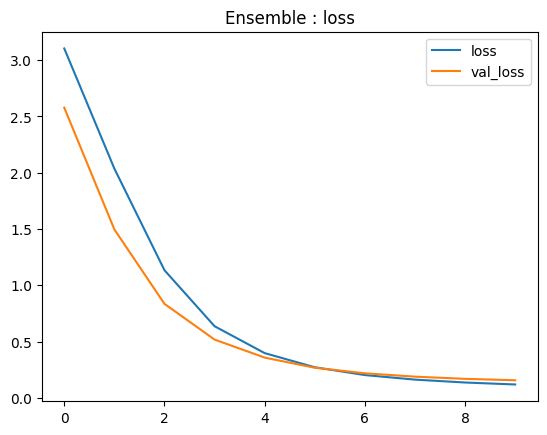

In [12]:
plt.plot(supmodel_history.history['loss'], label='loss')
plt.plot(supmodel_history.history['val_loss'], label='val_loss')
plt.title("Ensemble : loss")
plt.legend()
plt.show()

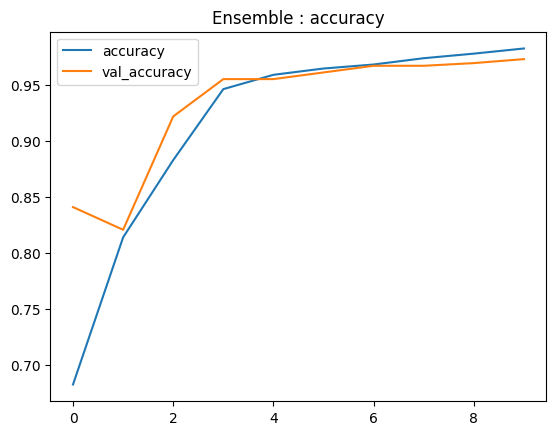

In [13]:
plt.plot(supmodel_history.history['accuracy'], label='accuracy')
plt.plot(supmodel_history.history['val_accuracy'], label='val_accuracy')
plt.title("Ensemble : accuracy")
plt.legend()
plt.show()